In [33]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import wandb
from sklearn.decomposition import PCA
import GPUtil
import os
import itertools
from torch.utils.data import random_split

# Loading the Data:
---

In [11]:
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

Following [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial for using CIFAR10

In [35]:
# Define the transformation to convert to grayscale and flatten to 1D
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Normalize((0.5,), (0.5,)),  # Normalize for grayscale
    transforms.Lambda(lambda x: x.view(-1)),  # Flatten the image to 1D
])


batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Define the size of the validation set as 20% of the training set
val_size = int(len(trainset) * 0.2)
train_size = len(trainset) - val_size

# Split the dataset into training and validation sets
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Here are some of the images in the CIFAR10 dataset in greyscale:

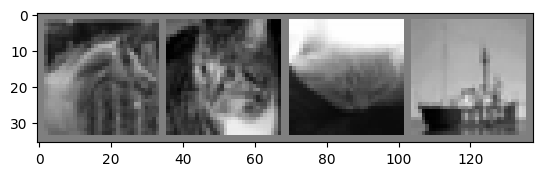

horse cat   cat   ship 


In [25]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

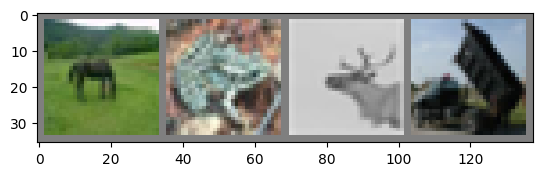

horse frog  deer  truck


In [ ]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Definitions:
---

In [3]:
def predict_embeddings(dataset, model, device, criterion):
    total_loss = 0

    model.eval() # Set model to evaluation mode
    predicted_embeddings = []
    output_name_encodings = []
    input_spectra_indices = []

    with torch.no_grad():
        for batch, name_encodings, true_embeddings, spectra_indices in dataset:
            batch = batch.to(device)
            true_embeddings = true_embeddings.to(device)

            batch_predicted_embeddings = model(batch)
            predicted_embeddings.append(batch_predicted_embeddings)
            output_name_encodings.append(name_encodings)
            input_spectra_indices.append(spectra_indices)

            loss = criterion(batch_predicted_embeddings, true_embeddings)
            # accumulate loss
            total_loss += loss.item()

    # divide by number of batches to calculate average loss
    average_loss = total_loss/len(dataset)
    return predicted_embeddings, output_name_encodings, average_loss, input_spectra_indices

In [4]:
def preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, emb_df, mass_spec_encoder_embeddings=False, mass_spec_chems=False):
    """
    Generate and plot a PCA visualization of predicted embeddings against corresponding ChemNet embeddings.

    Parameters:
    ----------
    predicted_embeddings : list of list of torch.Tensor
        A nested list of predicted embeddings, where each inner list contains tensors for a batch.

    output_name_encodings : list of list of torch.Tensor
        A nested list of one-hot encoded tensors representing the chemical names for the predicted embeddings.

    sorted_chem_names : list of str
        A list of chemical names corresponding to the indices of the one-hot encodings.

    emb_df : pandas.DataFrame
        A DataFrame containing true embeddings, with 'Embedding Floats' as one of its columns.

    log_wandb : boolean 
        True - log plot to wandb. False - do not log plot to wandb.

    Returns:
    -------
    A tuple containing:
    - true_embeddings (pd.DataFrame): DataFrame of true embeddings used for comparison.
    - predicted_embeddings_flattened (list): Flattened list of predicted embeddings.
    - chem_names (list): List of chemical names corresponding to the predicted embeddings.
    """

    # Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
    predicted_embeddings_flattened = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
    chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]

    # Get chemical names from encodings
    chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

    if mass_spec_encoder_embeddings:
        for emb in mass_spec_encoder_embeddings:
            predicted_embeddings_flattened.append(torch.Tensor(emb))
        chem_names += mass_spec_chems

    # making list of all embeddings and chem names except for BKG
    embeddings = [emb for emb in emb_df['Embedding Floats']][1:]
    cols = emb_df.index[1:]
    true_embeddings = pd.DataFrame(embeddings).T
    true_embeddings.columns = cols
    
    return (true_embeddings, predicted_embeddings_flattened, chem_names)

In [5]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_embeddings = []
  output_name_encodings = []

  for batch, name_encodings, true_embeddings, _ in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_embeddings = model(batch)

    loss = criterion(batch_predicted_embeddings, true_embeddings)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_embeddings, output_name_encodings
  else:
    return average_loss

In [31]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1024, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [8]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [9]:
def plot_emb_pca(all_embeddings, ims_embeddings, mass_spec_embeddings = None, log_wandb=True, chemnet_embeddings_to_plot=None):
    """
    Perform PCA on chemical embeddings and plot the transformed data, including IMS and Mass Spec embeddings if provided.

    Parameters:
    ----------
    all_embeddings : pd.DataFrame
        A dataframe containing ChemNet embeddings for all chemicals. 
        Each column represents one chemical's ChemNet embedding.
    ims_embeddings : pd.DataFrame
        A dataframe containing IMS (ion mobility spectrometry) embeddings. Must include a 'Label' column
        with chemical names and additional columns for embedding features.
    mass_spec_embeddings : pd.DataFrame, optional
        A dataframe containing mass spectrometry embeddings. Similar structure to `ims_embeddings`.
        Default is None, meaning mass spec embeddings are not included.
    log_wandb : bool, optional
        If True, logs the generated plot to Weights and Biases (wandb). Default is True.
    chemnet_embeddings_to_plot : pd.DataFrame, optional
        A dataframe containing ChemNet embeddings for all chemicals TO BE PLOTTED. 
        Each column represents one chemical's ChemNet embedding.

    Returns:
    -------
    None
        Displays the PCA scatter plot with ChemNet, IMS, and Mass Spec embeddings. 
        Optionally logs the plot to wandb if `log_wandb` is True.

    Notes:
    -----
    - PCA is performed on the transpose of `all_embeddings` so that embeddings for ims and mass spec data can be plotted to the same space.
    """ 
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    if chemnet_embeddings_to_plot is not None:
        transformed_embeddings = pca.transform(chemnet_embeddings_to_plot.T)
        all_chemical_names = list(chemnet_embeddings_to_plot.columns)
    else:
        transformed_embeddings = pca.transform(all_embeddings.T) 
        all_chemical_names = list(all_embeddings.columns)

    _, ax = plt.subplots(figsize=(8,6))

    # Create a color cycle for distinct colors
    color_cycle = plt.gca()._get_lines.prop_cycler

    ims_labels = list(ims_embeddings['Label'])
    if mass_spec_embeddings is not None:
        mass_spec_labels=list(mass_spec_embeddings['Label'])
    else:
        mass_spec_labels = False
    
    # Scatter plot
    for chem in all_chemical_names:
        idx = all_chemical_names.index(chem)
        color = next(color_cycle)['color']
        # only label 1st 8 chemicals to avoid giant legend
        # ax.scatter(0,0, color = color, label=chem)
        if idx < 8:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color, label=chem)#, s=200)
        else:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color)#, s=75)
        # Transform ims_embeddings for the current chemical, if we have ims data for chem
        if chem in ims_labels:
            # transform all data for the given chemical. Exclude last col (label)
            ims_transformed = pca.transform(ims_embeddings[ims_embeddings['Label'] == chem].iloc[:, :-1])
            
            # Scatter plot for ims_embeddings with a different marker
            ax.scatter(ims_transformed[:, 0], ims_transformed[:, 1], marker='o', facecolors='none', edgecolors=color)#marker='x', color=color)#, s=75)
        # repeat for mass spec
        if mass_spec_labels:
            if chem in mass_spec_labels:
                # transform all data for the given chemical. Exclude last col (label)
                mass_spec_transformed = pca.transform(mass_spec_embeddings[mass_spec_embeddings['Label'] == chem].iloc[:, :-1].values)
                
                # Scatter plot for mass_spec_embeddings with a different marker
                ax.scatter(mass_spec_transformed[:, 0], mass_spec_transformed[:, 1], marker='*', color=color, s=75)
    # Add legend
    legend1 = ax.legend(loc='upper right', title='Label')
    ax.add_artist(legend1)

    marker_legends = [
    plt.Line2D([0], [0], marker='o', color='w', label='ChemNet', markerfacecolor='black', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='IMS', markerfacecolor='none', markeredgecolor='black', markersize=6),
    ]
    
    if mass_spec_embeddings is not None:
        marker_legends.append(plt.Line2D([0], [0], marker='*', color='w', label='Mass Spec', markerfacecolor='black', markersize=10))

    # Add the second legend
    legend2 = ax.legend(handles=marker_legends, title='Marker Types', loc='upper left')
    ax.add_artist(legend2)

    plt.xticks([])
    plt.yticks([])
    plt.title('ChemNet vs. Encoder Output PCA', fontsize=18)

    if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'PCA of Predicted Chemical Embeddings': wandb.Image('tmp_plot.png')})

    plt.show()

In [10]:
def create_dataset_tensors(spectra_dataset, embedding_df, device, carl=False):
    # drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
    if carl: # carl dataset has no 'Unnamed: 0' column
        spectra = spectra_dataset.iloc[:,1:-9]
    else:
        spectra = spectra_dataset.iloc[:,2:-9]
    chem_encodings = spectra_dataset.iloc[:,-8:]

    # create tensors of spectra, true embeddings, and chemical name encodings for train and val
    chem_labels = list(spectra_dataset['Label'])
    embeddings_tensor = torch.Tensor([embedding_df['Embedding Floats'][chem_name] for chem_name in chem_labels]).to(device)
    spectra_tensor = torch.Tensor(spectra.values).to(device)
    chem_encodings_tensor = torch.Tensor(chem_encodings.values).to(device)
    spectra_indices_tensor = torch.Tensor(spectra_dataset['index']).to(device)

    return embeddings_tensor, spectra_tensor, chem_encodings_tensor, spectra_indices_tensor

# Setup:
---

## GPU:
---

In [14]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 0
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 24185.0 MB
  Memory Used: 31.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:0
PyTorch current device ID: 0
PyTorch current device name: NVIDIA GeForce RTX 4090


## Embeddings:
---

In [12]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


Currently embeddings are strings instead of a list of floats. Would be good to fix that in preprocessing.

In [13]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

# Train Encoder:
---

In [17]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/data_preprocessing/cifar10_encoder.ipynb'

In [ ]:
# set var deciding if embedding pca plot for this run is saved to wandb
save_emb_pca_to_wandb = True

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train.columns[-8:])

model_config = {
  'batch_size':[128],
  'epochs': [50],
  'learning_rate':[.0001]
  }

# loss to compare for each model. Starting at something high so it will be replaced by first model's loss 
lowest_loss = 100

# model_config = {
#     'batch_size': [128],
#     'epochs': [10],
#     'learning_rate': [.00001]
# }

keys = model_config.keys()
values = model_config.values()

# Generate all parameter combinations from model_config using itertools.product
combinations = itertools.product(*values)

# Iterate through each parameter combination and run model 
for combo in combinations:
  combo = dict(zip(keys, combo))

  train_dataset = DataLoader(TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_spectra_indices_tensor), batch_size=combo['batch_size'], shuffle=True)
  val_dataset = DataLoader(TensorDataset(val_spectra_tensor, val_chem_encodings_tensor, val_embeddings_tensor, val_spectra_indices_tensor), batch_size=combo['batch_size'], shuffle=False)
  encoder = Encoder().to(device)

  encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = combo['learning_rate'])
  encoder_criterion = nn.MSELoss()

  wandb_kwargs = {
    'learning_rate': combo['learning_rate'],
    'epochs': combo['epochs'],
    'batch_size': combo['batch_size'],
    'model_architecture': 'encoder',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
  }

  run_with_wandb(config, **wandb_kwargs)

  print('--------------------------')
  print('--------------------------')
  print('New run with hyperparameters:')
  for key in combo:
    print(key, ' : ', combo[key])

  for epoch in range(combo['epochs']):
    # if epoch == 10:
    #   lr = combo['learning_rate']*.1
    #   encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = lr)
    # if epoch == 30:
    #   encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = lr*.1)
    # Set model to training mode
    encoder.train(True)

    # do a pass over the data
    # at last epoch get predicted embeddings and chem names
    if (epoch + 1) == combo['epochs']:
      average_loss, predicted_embeddings, output_name_encodings = train_one_epoch(
        train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
        )
    else:
      average_loss = train_one_epoch(
        train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
        )

    epoch_val_loss = 0  
    # evaluate model on validation data
    encoder.eval() # Set model to evaluation mode
    with torch.no_grad():
      for val_batch, val_name_encodings, val_true_embeddings, val_spectra_indices in val_dataset:
        val_batch = val_batch.to(device)
        val_name_encodings = val_name_encodings.to(device)
        val_true_embeddings = val_true_embeddings.to(device)

        val_batch_predicted_embeddings = encoder(val_batch)

        val_loss = encoder_criterion(val_batch_predicted_embeddings, val_true_embeddings)
        # accumulate epoch validation loss
        epoch_val_loss += val_loss.item()

    # divide by number of batches to calculate average loss
    val_average_loss = epoch_val_loss/len(val_dataset)

    # log losses to wandb
    wandb.log({"Encoder Training Loss": average_loss, "Encoder Validation Loss": val_average_loss})

    if (epoch + 1) % 10 == 0:
      print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
      print(f'   Training loss: {average_loss}')
      print(f'   Validation loss: {val_average_loss}')
      print('-------------------------------------------')

  if save_emb_pca_to_wandb:
    true_embeddings, predicted_embeddings_flattened, chem_names = preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, name_smiles_embedding_df)

  if average_loss < lowest_loss:
    best_hyperparams = combo

  wandb.finish()

print('Hyperparameters for best model: ')
for key in best_hyperparams:
  print('   ', key, ' : ', best_hyperparams[key])

Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  128
epochs  :  50
learning_rate  :  0.0001
Epoch[10/50]:
   Training loss: 0.00011142320611964402
   Validation loss: 3.620427620117441e-05
-------------------------------------------
Epoch[20/50]:
   Training loss: 3.9596203010704045e-06
   Validation loss: 8.101717804861349e-06
-------------------------------------------
Epoch[30/50]:
   Training loss: 3.539328643104068e-06
   Validation loss: 5.5985220214560925e-06
-------------------------------------------
Epoch[40/50]:
   Training loss: 3.7543233499846377e-07
   Validation loss: 5.450002650279177e-06
-------------------------------------------
Epoch[50/50]:
   Training loss: 2.3225307006506287e-07
   Validation loss: 5.680882150885151e-06
-------------------------------------------


Encoder Training Loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Encoder Validation Loss,█▃▄▂█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Encoder Training Loss,0.0
Encoder Validation Loss,1e-05


Hyperparameters for best model: 
    batch_size  :  128
    epochs  :  50
    learning_rate  :  0.0001
